In [65]:
import os
import re
import zipfile
import kaggle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import collections
from collections import defaultdict
import pydotplus
import graphviz
%matplotlib inline
from scipy import stats
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, KBinsDiscretizer, LabelEncoder
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import make_scorer, accuracy_score, classification_report,confusion_matrix, plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.inspection import plot_partial_dependence, partial_dependence
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
INPUT_LOCATION = r"C:\Users\jwang\Desktop\20datasets\INPUT\1.ConversionRate"
OUTPUT_LOCATION = r"C:\Users\jwang\Desktop\20datasets\OUTPUT\1.ConversionRate"
INPUT_FILE_LOCATION = os.path.join(INPUT_LOCATION, 'conversion_project.csv')

# 1. Data Read-in and Exploration

In [3]:
df = pd.read_csv(INPUT_FILE_LOCATION)
exploration_df = df.copy()
exploration_df['agebin'] = pd.qcut(exploration_df['age'],10)
exploration_df.head()

,country,age,new_user,source,total_pages_visited,converted,agebin
0,UK,25,1,Ads,1,0,"(23.0, 25.0]"
1,US,23,1,Seo,5,0,"(20.0, 23.0]"
2,US,28,1,Seo,4,0,"(25.0, 28.0]"
3,China,39,1,Seo,5,0,"(38.0, 42.0]"
4,US,30,1,Seo,6,0,"(28.0, 30.0]"


In [4]:
exploration_df.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [5]:
print(exploration_df['country'].value_counts())
print(exploration_df['source'].value_counts())

US         178092
China       76602
UK          48450
Germany     13056
Name: country, dtype: int64
Seo       155040
Ads        88740
Direct     72420
Name: source, dtype: int64


## Some observations:
1. This may be a US website, but there are many Chinese customers. There should be more countries, but this dataset probably limits to the top 4.
2. There are some observations with age greater than 100. Need more check.
## Questions:
1. Is this data based on cookie or userid?
2. What is the conversion event?

In [6]:
exploration_df['age'].sort_values(ascending=False)
# We would want to drop age > 100. 
# This may be an indicator for a problem in the data collection code, so I may also need to talk to the engineer
# team about this problem. For example, they can add a data validation requiring age < 100.

90928     123
295581    111
265167     79
192644     77
154217     73
         ... 
39340      17
90844      17
118149     17
97994      17
229166     17
Name: age, Length: 316200, dtype: int64

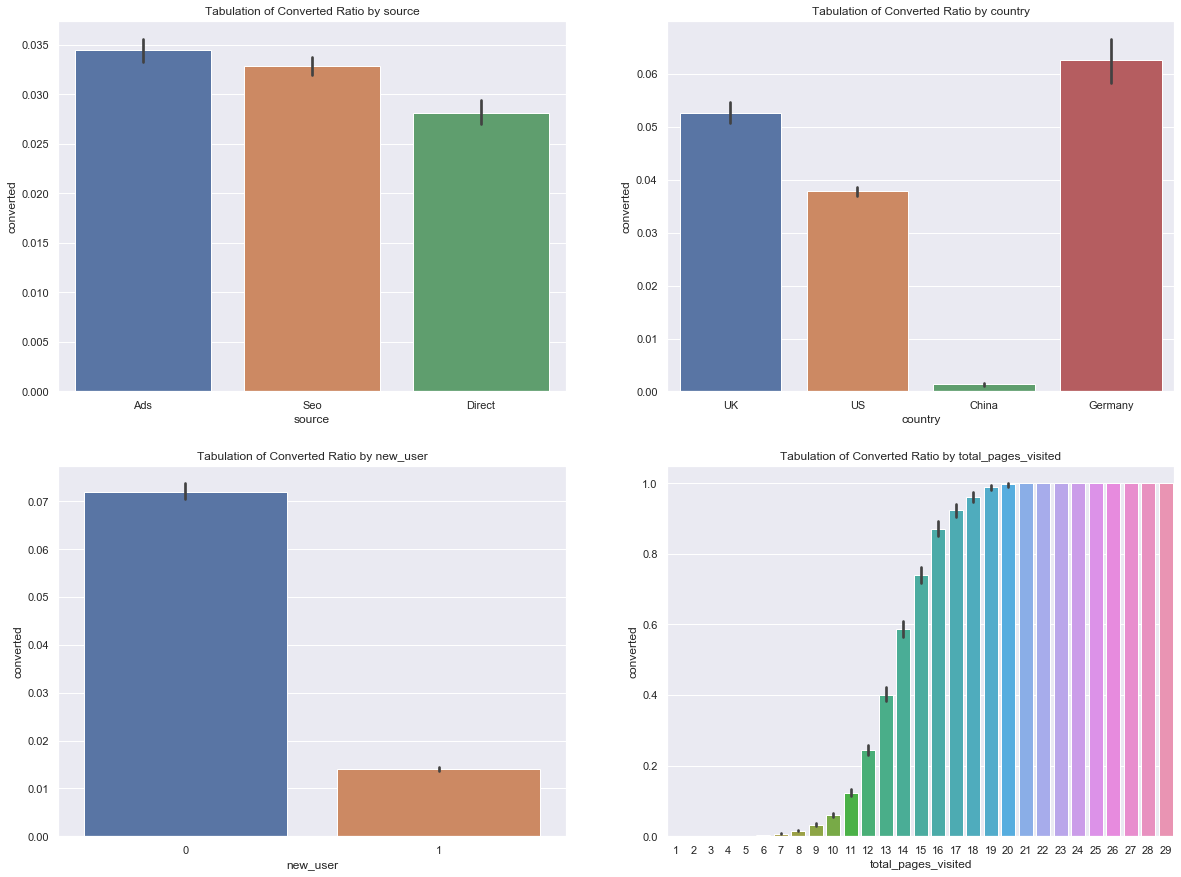

In [7]:
# Barplot with continuos variables into bins
sns.set()
fig,ax = plt.subplots(2,2, figsize=(20,15), sharey=False)
discrete_variables = ['source','country','new_user','total_pages_visited']
for column in range(2):
    for row in range(2):
        index = column + row*2
        var = discrete_variables[index]
        sns.barplot(x=var,  y= "converted", 
                    data=exploration_df, ax=ax[row,column]).set_title('Tabulation of Converted Ratio by '+var)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

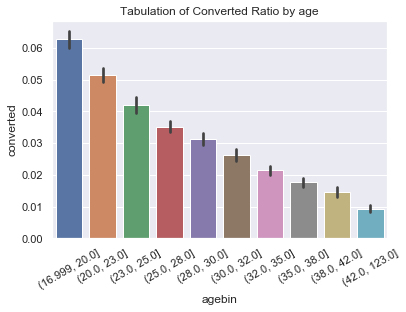

In [8]:
sns.barplot(x='agebin',  y= "converted", data=exploration_df).set_title('Tabulation of Converted Ratio by age')
plt.xticks(rotation=30)

# 2. Machine Learning Model

## 2.1 Data Preprocessing

In [9]:
df = df[df['age']<100]
df_train, df_validation = train_test_split(df, test_size=0.2, random_state=42)
print(df_train.shape)
print(df_validation.shape)
# Full set
X_fullset = df.drop('converted',axis=1)
y_fullset = df['converted']
# Training set
y_train = df_train["converted"]
X_train = df_train.drop('converted',axis=1)
# Validation set
y_validation = df_validation["converted"]
X_validation = df_validation.drop('converted',axis=1)

(252958, 6)
(63240, 6)


In [10]:
# Create dummies
class CategoricalDummies(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.categoricaldummy_list = ['new_user','source','country']
        return None
    def fit(self,X,y=None):
        self.categorical_dummies = OneHotEncoder(handle_unknown='ignore')
        self.categorical_dummies.fit(X[self.categoricaldummy_list])
        return self
    def transform(self, X, y=None):
        X_new = self.categorical_dummies.transform(X[self.categoricaldummy_list])
        feature_names = self.categorical_dummies.get_feature_names(self.categoricaldummy_list)
        X_new_dummies = pd.DataFrame.sparse.from_spmatrix(X_new, columns=feature_names, index=X.index)
        X_new = X.drop(self.categoricaldummy_list,axis=1).join(X_new_dummies)
        return X_new
class MultipleColumnEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.cat_list = ['source','country']
        return None
    def fit(self,X,y=None):
        self.label_dict = defaultdict(LabelEncoder)
        X_selected = X[self.cat_list]
        X_selected.apply(lambda c: self.label_dict[c.name].fit(c))
        return self
    def transform(self, X, y=None):
        X_new = X.copy()
        X_new[self.cat_list] = X_new[self.cat_list].apply(lambda c: self.label_dict[c.name].transform(c))
        return X_new
    def return_encoder_dict(self):
        return self.label_dict
# Preprocessor pipeline setup
preprocessor = Pipeline([('create_dummies',MultipleColumnEncoder())])
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_validation_preprocessed = preprocessor.transform(X_validation)
X_fullset_preprocessed = preprocessor.transform(X_fullset)
column_final = X_train_preprocessed.columns

## 2.2 DecisionTree

In [112]:
# Decision Tree
decisiontree = DecisionTreeClassifier()
accuracy_scorer = make_scorer(accuracy_score, greater_is_better=True)
max_depth_list = np.arange(4,7,1).tolist()
ccp_alpha_list = np.arange(0,1,0.1).tolist()
grid_search_decisiontree = GridSearchCV(decisiontree,[{'max_depth':max_depth_list}],scoring=accuracy_scorer,cv=10)
grid_search_decisiontree.fit(X_train_preprocessed, y_train)
tuned_decisiontree = grid_search_decisiontree.best_estimator_
tuned_decisiontree

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [113]:
# Model Evaluation
print("DecisionTree----Training set")
print(accuracy_score(y_train,tuned_decisiontree.predict(X_train_preprocessed)))
print("DecisionTree----Validation set")
print(accuracy_score(y_validation,tuned_decisiontree.predict(X_validation_preprocessed)))

DecisionTree----Training set
0.9859383771218938
DecisionTree----Validation set
0.9862745098039216


In [13]:
# Visualize decision tree
data = export_graphviz(tuned_decisiontree,feature_names=list(X_train_preprocessed.columns),
                       out_file=None,filled=True, rounded=True)
graph = graphviz.Source(data)
graph.render(r"C:\Users\jwang\Desktop\20datasets\OUTPUT\1.ConversionRate\tree.dot",view=True) 

'C:\\Users\\jwang\\Desktop\\20datasets\\OUTPUT\\1.ConversionRate\\tree.dot.pdf'

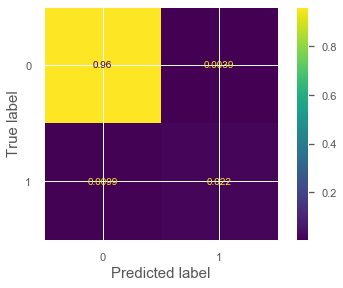

In [125]:
fig,ax = plt.subplots(figsize=(6,4))
ax.set_xlabel('a',fontsize=15)
ax.set_ylabel('a',fontsize=15)
plot_confusion_matrix(tuned_decisiontree, X_validation_preprocessed, y_validation, normalize='all',ax=ax)

## 2.3 Random Forest

In [15]:
# RandomForest
randomforest = RandomForestClassifier()
max_depth_list = np.arange(3,4,1).tolist()
max_feature_list = np.arange(1,4,1).tolist()
grid_search_randomforest = GridSearchCV(randomforest,
                        [{'max_depth':max_depth_list,
                          'max_features':[3]}],scoring=accuracy_scorer,cv=10)
grid_search_randomforest.fit(X_train_preprocessed, y_train)
tuned_randomforest = grid_search_randomforest.best_estimator_


In [16]:
print("Random Forest----Training set")
print(accuracy_score(y_train,tuned_randomforest.predict(X_train_preprocessed)))
print("Random Forest----Validation set")
print(accuracy_score(y_validation,tuned_randomforest.predict(X_validation_preprocessed)))

Random Forest----Training set
0.9851516852600036
Random Forest----Validation set
0.9856894370651487


## 2.4 Result Visualization

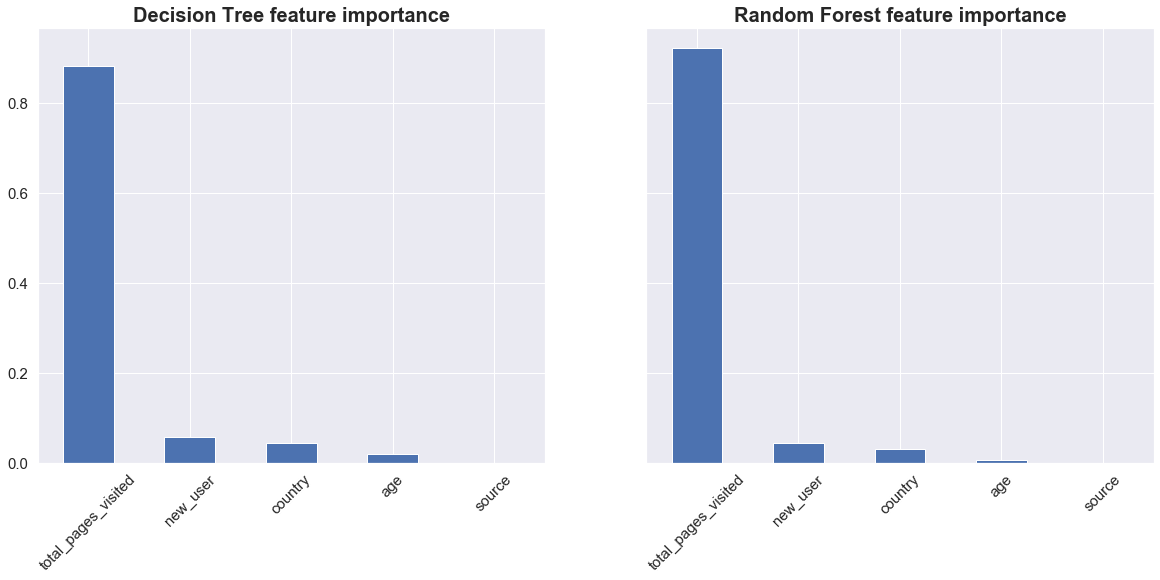

In [17]:
def df_feature_importance(plot_tree, nopage=False):
    feature_importance_list = plot_tree.feature_importances_
    if nopage==True:
        feature_names =list(X_train_preprocessed.drop('total_pages_visited',axis=1).columns)
    else:
        feature_names =list(X_train_preprocessed.columns)        
    feature_importance_map = {feature_names[i]:feature_importance_list[i] for i in range(0,len(feature_importance_list))}
    feature_importance = pd.Series(feature_importance_map)
    feature_importance = feature_importance.sort_values(ascending=False)
    return feature_importance

fig,ax = plt.subplots(1,2,figsize=(20,8), sharey=True)
df_feature_importance(tuned_decisiontree).plot.bar(ax=ax[0])
df_feature_importance(tuned_randomforest).plot.bar(ax=ax[1])
ax[0].set_title("Decision Tree feature importance",fontweight="bold", size=20)
ax[1].set_title("Random Forest feature importance",fontweight="bold", size=20)
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45,fontsize=15)
    plt.yticks(fontsize=15)

### Understanding of the model
1. total_pages_visited is the most important feature, but unfortunately also least "actionable". People visit the webpages because they want to buy your products.
2. Therefore, we should test a model where total_pages_visited is excluded.
3. Both randomforest and decisiontree agree that new user, China, and age can be three most important factors that affect conversion ratio. We will see if this is still the case without total_page_visited.

## 2.5 Rerun DecisionTree without total_pages_visited

In [130]:
# Decision Tree
decisiontree_nopage = DecisionTreeClassifier(class_weight={0:1,1:10})
accuracy_scorer = make_scorer(accuracy_score, greater_is_better=True)
max_depth_list = np.arange(4,8,1).tolist()
ccp_alpha_list = np.arange(0,1,0.1).tolist()
grid_search_decisiontree_nopage = GridSearchCV(decisiontree_nopage,[{'max_depth':max_depth_list}],
                                               scoring=accuracy_scorer,cv=10)
grid_search_decisiontree_nopage.fit(X_train_preprocessed.drop('total_pages_visited',axis=1), y_train)
tuned_decisiontree_nopage = grid_search_decisiontree_nopage.best_estimator_

Decision Tree drop total_page_visited----Training set
0.8924248294183225
Decision Tree drop total_page_visited----Validation set
0.8927261227071474


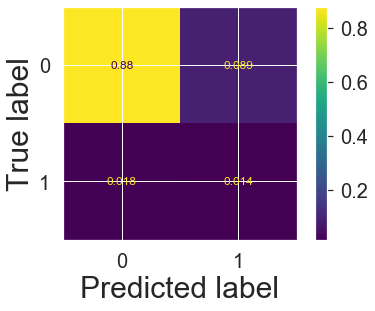

In [131]:
print("Decision Tree drop total_page_visited----Training set")
print(accuracy_score(y_train,
                     tuned_decisiontree_nopage.predict(X_train_preprocessed.drop('total_pages_visited',axis=1))))
print("Decision Tree drop total_page_visited----Validation set")
print(accuracy_score(y_validation,
                     tuned_decisiontree_nopage.predict(X_validation_preprocessed.drop('total_pages_visited',axis=1))))
fig,ax = plt.subplots(figsize=(6,4))
plot_confusion_matrix(tuned_decisiontree_nopage, 
                      X_validation_preprocessed.drop('total_pages_visited',axis=1), y_validation, normalize='all',ax=ax)

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 <a list of 7 Text yticklabel objects>)

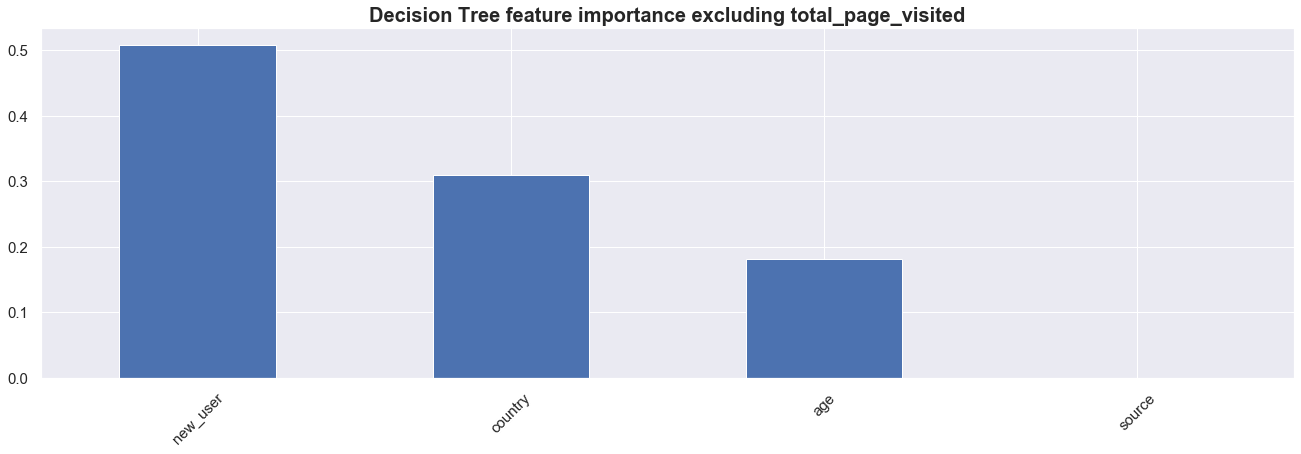

In [132]:
# Visualizing
fig,ax = plt.subplots(1,1,figsize=(20,6), sharey=True)
df_feature_importance(tuned_decisiontree_nopage,nopage=True).plot.bar()
ax.set_title("Decision Tree feature importance excluding total_page_visited",fontweight="bold", size=20)
plt.xticks(rotation=45,fontsize=15)
plt.yticks(fontsize=15)

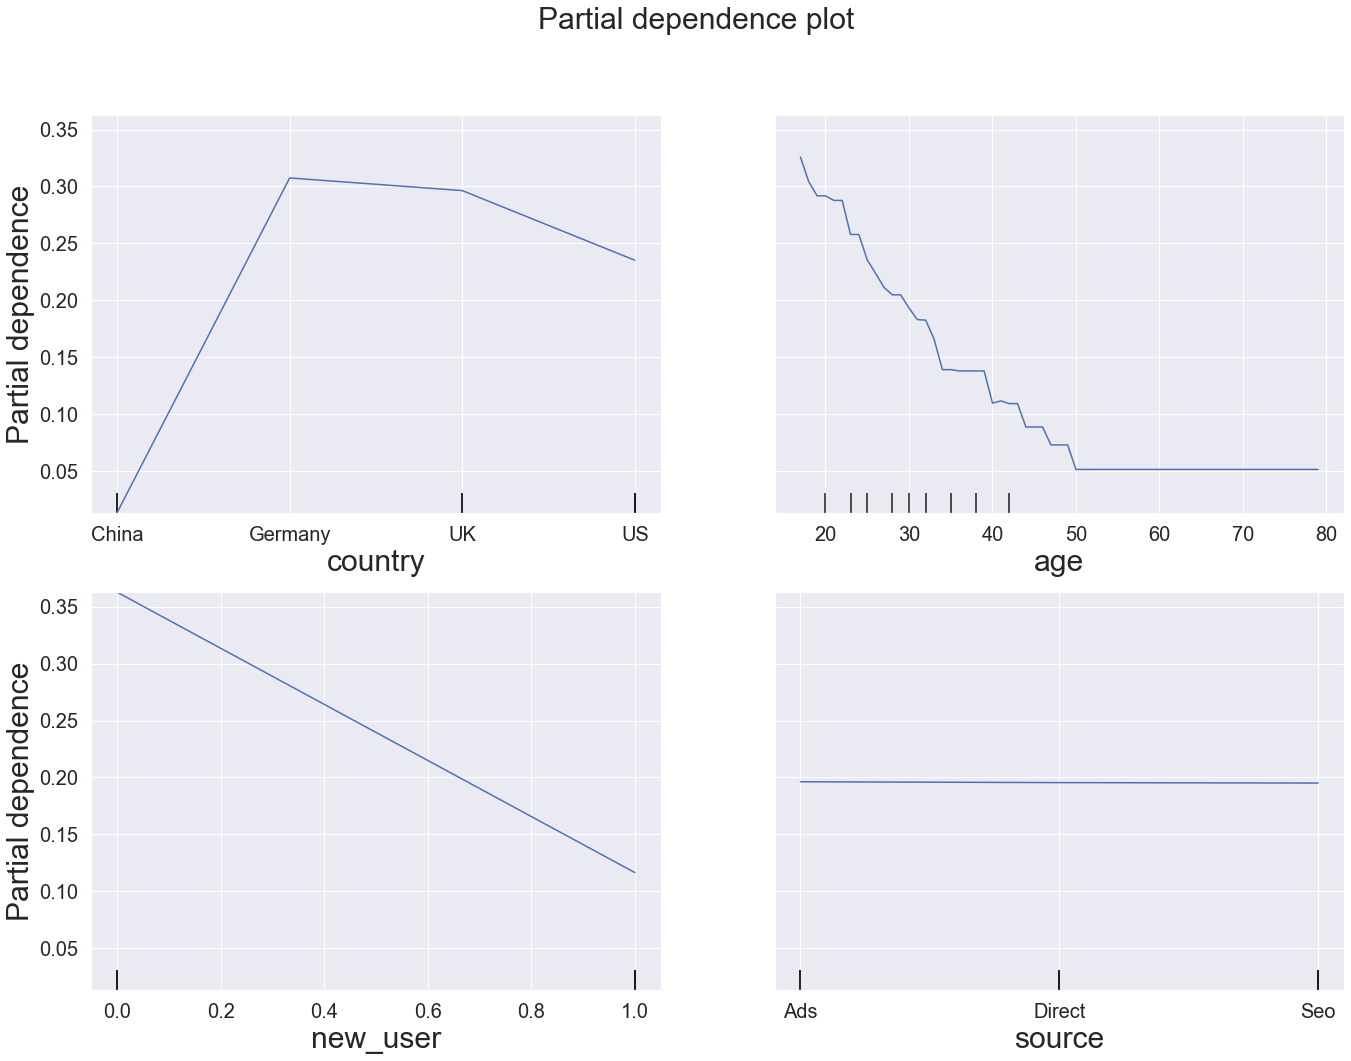

In [133]:
fig,ax = plt.subplots(2,2,figsize=(20,15))
fig.suptitle("Partial dependence plot", fontsize=30)
sns.set(rc={"font.style":"normal",
            "axes.titlesize":30,
            'axes.labelsize':30,
            'figure.figsize':(10, 10),
            'xtick.labelsize':20,
            'ytick.labelsize':20})

encoder_dict = preprocessor['create_dummies'].return_encoder_dict()
country_encoder = encoder_dict['country']
country_dict = dict(zip(country_encoder.transform(country_encoder.classes_), country_encoder.classes_))
source_encoder = encoder_dict['source']
source_dict = dict(zip(source_encoder.transform(source_encoder.classes_), source_encoder.classes_))

from matplotlib.ticker import FuncFormatter, MaxNLocator
def format_country(tick_val, tick_pos):
    if tick_val in list(country_dict.keys()):
        return country_dict[tick_val]
    else:
        return ''

ax[0,0].xaxis.set_major_formatter(FuncFormatter(format_country))
ax[0,0].xaxis.set_major_locator(MaxNLocator(integer=True))

def format_source(tick_val, tick_pos):
    if tick_val in list(source_dict.keys()):
        return source_dict[tick_val]
    else:
        return ''

ax[0,0].xaxis.set_major_formatter(FuncFormatter(format_country))
ax[0,0].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1,1].xaxis.set_major_formatter(FuncFormatter(format_source))
ax[1,1].xaxis.set_major_locator(MaxNLocator(integer=True))

plot_partial_dependence(tuned_decisiontree_nopage, features=[0,1,2,3], 
                        X=X_train_preprocessed.drop('total_pages_visited',axis=1),ax=ax)

In [138]:
# Decision Tree
decisiontree_simple = DecisionTreeClassifier(class_weight={0:1,1:10})
accuracy_scorer = make_scorer(accuracy_score, greater_is_better=True)
grid_search_decisiontree_simple = GridSearchCV(decisiontree_simple,[{'max_depth':[3]}],
                                               scoring=accuracy_scorer,cv=10)
grid_search_decisiontree_simple.fit(X_train_preprocessed.drop('total_pages_visited',axis=1), y_train)
tuned_decisiontree_simple = grid_search_decisiontree_simple.best_estimator_


'C:\\Users\\jwang\\Desktop\\20datasets\\OUTPUT\\1.ConversionRate\\simpletree.dot.pdf'

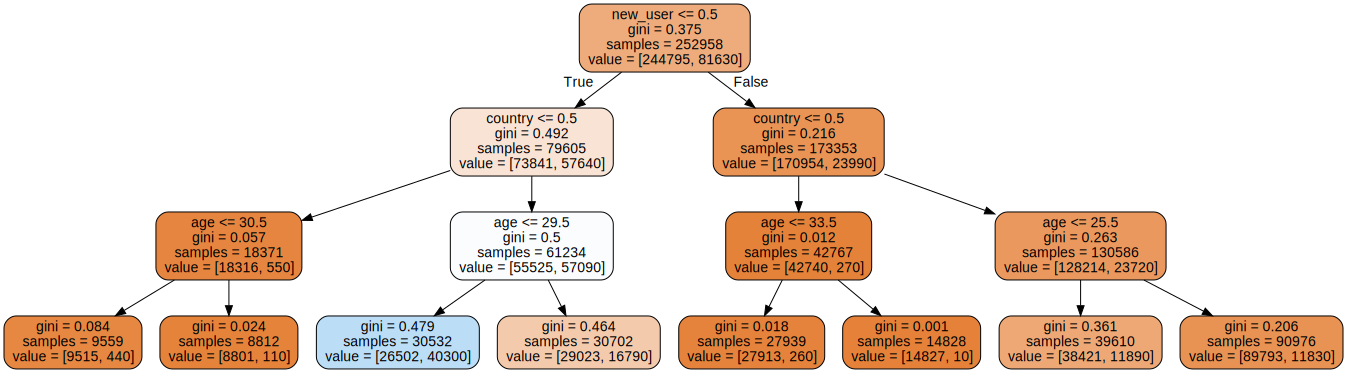

In [143]:
# Visualize decision tree
data = export_graphviz(tuned_decisiontree_simple,
                       feature_names=list(X_train_preprocessed.drop('total_pages_visited',axis=1).columns),
                       out_file=None,filled=True, rounded=True)
graph = graphviz.Source(data)
graph